<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Creating-and-Plotting-an-Environment" data-toc-modified-id="Creating-and-Plotting-an-Environment-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Creating and Plotting an Environment</a></span></li><li><span><a href="#State/Observation-and-Action-Spaces" data-toc-modified-id="State/Observation-and-Action-Spaces-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>State/Observation and Action Spaces</a></span></li><li><span><a href="#Simulating-a-Random-Agent" data-toc-modified-id="Simulating-a-Random-Agent-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Simulating a Random Agent</a></span></li><li><span><a href="#Creating-an-Animation" data-toc-modified-id="Creating-an-Animation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Creating an Animation</a></span></li><li><span><a href="#Creating-an-Image-Observation" data-toc-modified-id="Creating-an-Image-Observation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Creating an Image Observation</a></span></li><li><span><a href="#Choosing-an-Action-with-a-NN" data-toc-modified-id="Choosing-an-Action-with-a-NN-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Choosing an Action with a NN</a></span></li><li><span><a href="#Training-the-Policy-NN" data-toc-modified-id="Training-the-Policy-NN-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Training the Policy NN</a></span></li><li><span><a href="#Viewing-Results" data-toc-modified-id="Viewing-Results-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Viewing Results</a></span></li></ul></div>

# Deep Reinforcement Learning

![DQN RL](https://pytorch.org/tutorials/_images/reinforcement_learning_diagram.jpg)

From the PyTorch [Reinforcement Learning (DQN) Tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html).

## Imports

In [1]:
from collections import deque, namedtuple
from itertools import count
import random

import gym
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T

from fastprogress import master_bar, progress_bar

from celluloid import Camera

# Create a virtual display for rendering the environment
import pyvirtualdisplay

_ = pyvirtualdisplay.Display(visible=False).start()

## Creating and Plotting an Environment

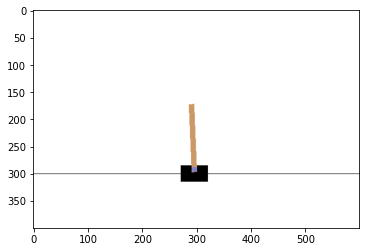

In [2]:
env = gym.make("CartPole-v0")
env.reset()

frame = env.render(mode="rgb_array")
_ = plt.imshow(frame)

## State/Observation and Action Spaces

In [3]:
print("Observation space:\n\t", env.observation_space)
print("Action space:\n\t", env.action_space)

Observation space:
	 Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space:
	 Discrete(2)


## Simulating a Random Agent

In [4]:
num_episodes = 4
max_steps = 1000

for episode in progress_bar(range(num_episodes)):

    observation = env.reset()

    for t in count():

        action = env.action_space.sample()

        observation, reward, complete, info = env.step(action)

        if complete:
            print(f"Stopping after {t} steps.")
            break

env.close()

Stopping after 39 steps.
Stopping after 15 steps.
Stopping after 27 steps.
Stopping after 19 steps.


## Creating an Animation

In [5]:
obs = env.reset()
frames = [env.render(mode="rgb_array")]

for t in count():

    action = env.action_space.sample()

    obs, reward, complete, info = env.step(action)

    frames.append(env.render(mode="rgb_array"))

    if complete:
        print(f"Stopping after {t} steps.")
        break

env.close()

Stopping after 10 steps.


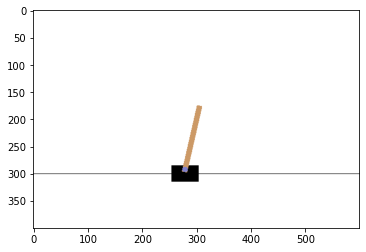

In [6]:
fig = plt.figure()
camera = Camera(fig)

for frame in frames:
    plt.imshow(frame)
    camera.snap()

animation = camera.animate()
HTML(animation.to_jshtml())

## Creating an Image Observation

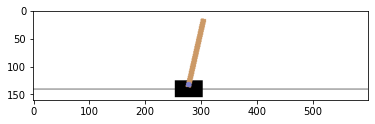

In [7]:
fheight, fwidth, _ = frame.shape

crop_height_min = int(fheight * 0.4)
crop_height_max = int(fheight * 0.8)

frame_cropped = frame[crop_height_min:crop_height_max, :, :]

_ = plt.imshow(frame_cropped)

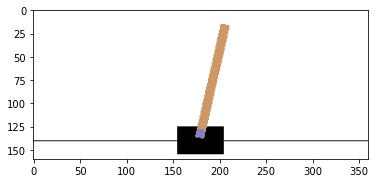

In [8]:
crop_width = int(fwidth * 0.6)

ewidth = env.x_threshold * 2
width_scale = fwidth / ewidth

epos = env.state[0]
spos = int(epos * width_scale + fwidth / 2)
spos

crop_width_min = spos - crop_width // 2
crop_width_max = spos + crop_width // 2

frame_cropped = frame[crop_height_min:crop_height_max, crop_width_min:crop_width_max, :]

_ = plt.imshow(frame_cropped)

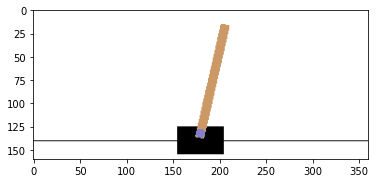

In [9]:
frame_cropped_float = frame_cropped / 255
frame_cropped_float = torch.from_numpy(frame_cropped_float)
_ = plt.imshow(frame_cropped_float)

torch.Size([3, 160, 360])


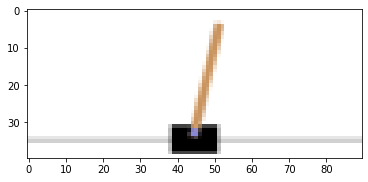

In [10]:
frame_permuted = frame_cropped_float.permute(2, 0, 1)
print(frame_permuted.shape)

xform = T.Compose(
    [
        T.ToPILImage(),
        T.Resize(40, interpolation=T.InterpolationMode.BICUBIC),
        T.ToTensor(),
    ]
)

x = xform(frame_permuted)

_ = plt.imshow(x.permute(1, 2, 0).numpy())

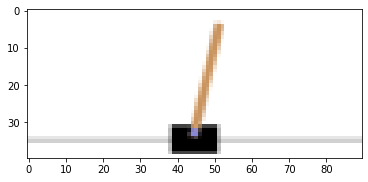

In [11]:
new_height = 40

frame_xforms = T.Compose(
    [
        T.ToPILImage(),
        T.Resize(new_height, interpolation=T.InterpolationMode.BICUBIC),
        T.ToTensor(),
    ]
)


def prepare_frame(frame):
    fheight, fwidth, _ = frame.shape

    crop_height_min = int(fheight * 0.4)
    crop_height_max = int(fheight * 0.8)

    crop_width = int(fwidth * 0.6)

    ewidth = env.x_threshold * 2
    width_scale = fwidth / ewidth

    epos = env.state[0]
    spos = int(epos * width_scale + fwidth / 2)

    crop_width_min = spos - crop_width // 2
    crop_width_max = spos + crop_width // 2

    cframe = frame[crop_height_min:crop_height_max, crop_width_min:crop_width_max, :]
    tframe = torch.from_numpy(cframe / 255).permute(2, 0, 1)

    return frame_xforms(tframe).unsqueeze(0)


_ = plt.imshow(prepare_frame(frame).squeeze().permute(1, 2, 0).numpy())

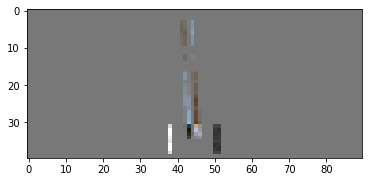

In [12]:
env.reset()

frame1 = env.render(mode="rgb_array")

env.step(1)
env.step(1)
env.step(1)
env.step(1)

frame2 = env.render(mode="rgb_array")

env.close()

pframe1 = prepare_frame(frame1)
pframe2 = prepare_frame(frame2)

state = pframe2 - pframe1

# Scale between 0 and 1 for rendering
state += state.min().abs()
state /= state.max()

_ = plt.imshow(state.squeeze().permute(1, 2, 0).numpy())

## Choosing an Action with a NN

In [13]:
num_episodes = 4

for episode in progress_bar(range(num_episodes)):

    env.reset()
    prev_frame = prepare_frame(env.render(mode="rgb_array"))
    curr_frame = prev_frame
    state = curr_frame - prev_frame

    for t in count():

        # How do we choose an action?
        #         action = ...
        #         obs, reward, complete, info = env.step(action)

        prev_frame = curr_frame
        curr_frame = env.render(mode="rgb_array")

        # How do we optimize?

        if complete:
            break

env.close()

In [14]:
def conv_output_size(size, kernel_size, stride):
    return (size - (kernel_size - 1) - 1) // stride + 1


class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()

        F = 5
        S = 2

        K0 = 3
        K1 = 16
        self.conv1 = nn.Conv2d(K0, K1, kernel_size=F, stride=S)
        self.bn1 = nn.BatchNorm2d(K1)

        h1 = conv_output_size(h, F, S)
        w1 = conv_output_size(w, F, S)

        K2 = 32
        self.conv2 = nn.Conv2d(K1, K2, kernel_size=F, stride=S)
        self.bn2 = nn.BatchNorm2d(K2)

        h2 = conv_output_size(h1, F, S)
        w2 = conv_output_size(w1, F, S)

        K3 = 32
        self.conv3 = nn.Conv2d(K2, K3, kernel_size=F, stride=S)
        self.bn3 = nn.BatchNorm2d(K3)

        h3 = conv_output_size(h2, F, S)
        w3 = conv_output_size(w2, F, S)

        linear_input_size = h3 * w3 * 32
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [15]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

In [16]:
frame = prepare_frame(env.render(mode="rgb_array"))
env.close()
_, _, fheight, fwidth = frame.shape

num_actions = env.action_space.n

policy = DQN(fheight, fwidth, num_actions)
policy_stable = DQN(fheight, fwidth, num_actions)
policy_stable.load_state_dict(policy.state_dict())
policy_stable.eval()

optimizer = optim.RMSprop(policy.parameters())
criterion = nn.SmoothL1Loss()

In [17]:
def select_action(policy, state, step, num_actions):
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1.0 * step / EPS_DECAY)
    step += 1
    r = random.random()
    if r > eps_threshold:
        with torch.no_grad():
            return policy(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(num_actions)]], dtype=torch.long)

In [18]:
select_action(policy, state, 100, 2)

tensor([[0]])

In [19]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [24]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool
    )

    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE)
    next_state_values[non_final_mask] = (
        policy_stable(non_final_next_states).max(1)[0].detach()
    )
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in policy.parameters():
        param.grad.data.clamp_(-1, 1)

    print(loss.item())
    optimizer.step()

## Training the Policy NN

In [25]:
num_episodes = 12
step = 0

memory = ReplayMemory(10000)

for episode in progress_bar(range(num_episodes)):

    env.reset()
    prev_frame = prepare_frame(env.render(mode="rgb_array"))
    curr_frame = prev_frame
    state = curr_frame - prev_frame

    print("Starting episode", episode)

    for t in count():

        action = select_action(policy, state, step, num_actions)

        _, reward, complete, _ = env.step(action.item())

        reward = torch.tensor([reward])

        # Observe new state
        prev_frame = curr_frame
        curr_frame = prepare_frame(env.render(mode="rgb_array"))

        # Treat the final state differently
        if not complete:
            next_state = curr_frame - prev_frame
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        optimize_model()

        if complete:
            break

    # Update the stable network, copying all weights and biases in DQN
    if episode % TARGET_UPDATE == 0:
        policy_stable.load_state_dict(policy.state_dict())

print("Complete")
env.close()

Starting episode 0
Starting episode 1
Starting episode 2
Starting episode 3
0.3099634051322937
0.24760103225708008
0.2874079942703247
0.20894905924797058
0.2138880491256714
0.16987518966197968
0.17039135098457336
0.1618742048740387
0.17454886436462402
0.15587443113327026
0.15409131348133087
0.12807349860668182
0.13378646969795227
0.11467007547616959
0.10835824906826019
0.10812241584062576
0.09450189024209976
0.10471732914447784
0.13406509160995483
0.15406866371631622
0.17494799196720123
0.16970717906951904
0.17601004242897034
0.1624910533428192
0.24142958223819733
0.16812294721603394
0.17378409206867218
Starting episode 4
0.15892191231250763
0.17068730294704437
0.14158441126346588
0.1383088231086731
0.1438751220703125
0.17097793519496918
0.19394339621067047
0.22507017850875854
0.14481870830059052
Starting episode 5
0.13383589684963226
0.11992578208446503
0.1184341236948967
0.1060984879732132
0.12017709761857986
0.11992381513118744
0.12152375280857086
0.08761933445930481
0.1013654321432

## Viewing Results

In [26]:
env.reset()
prev_frame = prepare_frame(env.render(mode="rgb_array"))
curr_frame = prev_frame
state = curr_frame - prev_frame

frames = [curr_frame]

for t in count():

    with torch.no_grad():
        action = policy(state).max(1)[1].view(1, 1).item()

    obs, reward, complete, info = env.step(action)

    # Observe new state
    prev_frame = curr_frame
    curr_frame = prepare_frame(env.render(mode="rgb_array"))
    frames.append(curr_frame)
    
    if complete:
        print(f"Stopping after {t} steps.")
        break

env.close()

Stopping after 9 steps.


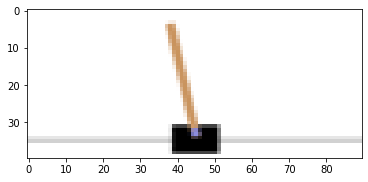

In [23]:
fig = plt.figure()
camera = Camera(fig)

for frame in frames:
    plt.imshow(frame.squeeze().permute(1, 2, 0))
    camera.snap()

animation = camera.animate()
HTML(animation.to_jshtml())